# Importing Libraries

In [0]:
import numpy as np
from keras import models
from keras import layers
from keras import optimizers
from keras.applications import InceptionResNetV2
from keras.preprocessing.image import ImageDataGenerator

from matplotlib.pyplot import imshow
%matplotlib inline

# Download Dataset

In [3]:
!wget http://www.recod.ic.unicamp.br/~feandalo/MO444_dogs.tar.gz

--2018-05-24 22:58:49--  http://www.recod.ic.unicamp.br/~feandalo/MO444_dogs.tar.gz
Resolving www.recod.ic.unicamp.br (www.recod.ic.unicamp.br)... 143.106.7.151
Connecting to www.recod.ic.unicamp.br (www.recod.ic.unicamp.br)|143.106.7.151|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1260424819 (1.2G) [application/x-gzip]
Saving to: ‘MO444_dogs.tar.gz’

MO444_dogs.tar.gz    84%[===============>    ]   1010M  24.2MB/s    eta 10s    

MO444_dogs.tar.gz   100%[===================>]   1.17G  24.3MB/s    in 57s     

2018-05-24 22:59:46 (21.1 MB/s) - ‘MO444_dogs.tar.gz’ saved [1260424819/1260424819]



In [0]:
# Extracting file
!apt-get install p7zip-full
!7z e MO444_dogs.tar.gz
!tar -xvf MO444_dogs.tar

# Importing Dataset From Google Drive

In [2]:
# Installing PyDrive
!pip install PyDrive

    100% |████████████████████████████████| 993kB 12.4MB/s 
  Running setup.py bdist_wheel for PyDrive ... - \ done
  Stored in directory: /content/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built PyDrive


In [0]:
# Authenticating user
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# Verify list of google drive's IDs
file_list = drive.ListFile({'q': "'root' in parents and trashed=false"}).GetList()
for file1 in file_list:
  if file1['title'] == 'dogbreed.zip':
    ID = file1['id']

In [6]:
# Searching the dataset in google drive
fileId = drive.CreateFile({'id': ID})
print(fileId['title'])
fileId.GetContentFile('dogbreed.zip')

dogbreed.zip


In [0]:
%%capture
# Unzipping the dataset
!unzip dogbreed.zip

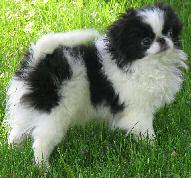

In [41]:
# Verifing one example of the dataset
from IPython.display import Image
Image('MO444_dogs/train/54/54_0000.jpg')

# Download Convolution Network

In [9]:
incept_v2 = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

219062272/219055592 [==============================] - 10s 0us/step


In [82]:
# Freeze the layers except the last 4 layers
for layer in incept_v2.layers[:-4]:
    layer.trainable = False
    
# Check the trainable status of the individual layers
for layer in incept_v2.layers:
    print(layer, layer.trainable)

<keras.engine.topology.InputLayer object at 0x7fe4e6fa3470> False
<keras.layers.convolutional.Conv2D object at 0x7fe4e6fa37f0> False
<keras.layers.normalization.BatchNormalization object at 0x7fe4e750e6d8> False
<keras.layers.core.Activation object at 0x7fe52602f780> False
<keras.layers.convolutional.Conv2D object at 0x7fe4e707bda0> False
<keras.layers.normalization.BatchNormalization object at 0x7fe4e700de48> False
<keras.layers.core.Activation object at 0x7fe4e16f5668> False
<keras.layers.convolutional.Conv2D object at 0x7fe4e1699278> False
<keras.layers.normalization.BatchNormalization object at 0x7fe4e16a9a90> False
<keras.layers.core.Activation object at 0x7fe4e15d65c0> False
<keras.layers.pooling.MaxPooling2D object at 0x7fe4e159b9b0> False
<keras.layers.convolutional.Conv2D object at 0x7fe4e15f5fd0> False
<keras.layers.normalization.BatchNormalization object at 0x7fe4e15b8f28> False
<keras.layers.core.Activation object at 0x7fe4e153d400> False
<keras.layers.convolutional.Conv2D 

# Modifiying Model

In [83]:
# Create the model
model = models.Sequential()
 
# Add the vgg convolutional base model
model.add(incept_v2)

# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(83, activation='softmax'))
 
# Show a summary of the model. Check the number of trainable parameters
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 8, 8, 1536)        54336736  
_________________________________________________________________
flatten_7 (Flatten)          (None, 98304)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 1024)              100664320 
_________________________________________________________________
dropout_6 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 83)                85075     
Total params: 155,086,131
Trainable params: 103,945,811
Non-trainable params: 51,140,320
_________________________________________________________________


In [74]:
class TensorBoardWrapper(TensorBoard):
    '''Sets the self.validation_data property for use with TensorBoard callback.'''

    def __init__(self, batch_gen, nb_steps, **kwargs):
        super().__init__(**kwargs)
        self.batch_gen = batch_gen # The generator.
        self.nb_steps = nb_steps     # Number of times to call next() on the generator.

    def on_epoch_end(self, epoch, logs):
        # Fill in the `validation_data` property. Obviously this is specific to how your generator works.
        # Below is an example that yields images and classification tags.
        # After it's filled in, the regular on_epoch_end method has access to the validation_data.
        imgs, tags = None, None
        for s in range(self.nb_steps):
            ib, tb = next(self.batch_gen)
            if imgs is None and tags is None:
                imgs = np.zeros((self.nb_steps * ib.shape[0], *ib.shape[1:]), dtype=np.float32)
                tags = np.zeros((self.nb_steps * tb.shape[0], *tb.shape[1:]), dtype=np.uint8)
            imgs[s * ib.shape[0]:(s + 1) * ib.shape[0]] = ib
            tags[s * tb.shape[0]:(s + 1) * tb.shape[0]] = tb
        self.validation_data = [imgs, tags, np.ones(imgs.shape[0]), 0.0]
        return super().on_epoch_end(epoch, logs)


from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
class Metrics(Callback):
  def on_train_begin(self, logs={}):
   self.val_f1s = []
   self.val_recalls = []
   self.val_precisions = []

  def on_epoch_end(self, epoch, logs={}):
   val_predict = (np.asarray(self.model.predict(self.model.validation_data[0]))).round()
   val_targ = self.model.validation_data[1]
   _val_f1 = f1_score(val_targ, val_predict)
   _val_recall = recall_score(val_targ, val_predict)
   _val_precision = precision_score(val_targ, val_predict)
   self.val_f1s.append(_val_f1)
   self.val_recalls.append(_val_recall)
   self.val_precisions.append(_val_precision)
   print('— val_f1: %f — val_precision: %f — val_recall %f'%(_val_f1, _val_precision, _val_recall))
   return
 
metrics = Metrics()

NameError: ignored

# Generating Validation and Training Set

In [74]:
train_dir = 'MO444_dogs/train/'
validation_dir = 'MO444_dogs/val/'

image_size = (299, 299)

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 

train_batchsize = 10
val_batchsize = 10
 
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=image_size,
        batch_size=train_batchsize,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=image_size,
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 8300 images belonging to 83 classes.
Found 6022 images belonging to 83 classes.


# Compiling the model

In [84]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])
# Train the model
model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=5,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)
 
# Save the model
#model.save('small_last4.h5')

Epoch 1/2
830/830 [==============================] - 603s 727ms/step - loss: 2.8984 - acc: 0.4870 - val_loss: 0.4388 - val_acc: 0.9176
Epoch 2/2
107/830 [==>...........................] - ETA: 5:02 - loss: 1.4770 - acc: 0.6832

830/830 [==============================] - 573s 691ms/step - loss: 1.5131 - acc: 0.7035 - val_loss: 0.4728 - val_acc: 0.9253


In [90]:
predictions = model.predict_generator(validation_generator, steps=validation_generator.samples/validation_generator.batch_size,verbose=1)
print(predictions)

603/602 [==============================] - 227s 377ms/step
[[9.98823583e-01 8.58963358e-06 4.92080376e-10 ... 4.04251405e-05
  1.38833411e-06 6.25276662e-05]
 [1.00000000e+00 7.06290800e-15 1.91677510e-19 ... 2.17577276e-11
  6.36660350e-16 1.69443127e-12]
 [1.00000000e+00 7.70500132e-16 8.81173082e-20 ... 2.54261781e-13
  9.84965513e-17 2.69263832e-13]
 ...
 [4.29900160e-09 7.16231455e-07 8.95844843e-10 ... 1.26490916e-08
  5.86891924e-11 9.96922433e-01]
 [3.92388483e-11 1.82194579e-10 1.30656888e-10 ... 6.39406084e-10
  6.47775670e-13 9.99997497e-01]
 [3.93749311e-10 4.09028855e-09 3.36067480e-12 ... 2.42393350e-09
  1.14876832e-11 9.89682615e-01]]


In [136]:
np.shape(predictions)
print(np.argmax(prediction[3:]))
pred_class = np.argmax(predictions, axis=1)
ground_truth = validation_generator.classes
print(pred_class, ground_truth)

i = 0

for i in range(len(pred_class)):
  if pred_class[i] != ground_truth[i]:
    i+=1
print(i)

77
[ 0  0  0 ... 82 82 82] [ 0  0  0 ... 82 82 82]
6021


I think this digit is a 67 with 97.59702682495117% confidence.
I think this digit is a 80 with 99.99998807907104% confidence.
I think this digit is a 80 with 99.99998807907104% confidence.
I think this digit is a 80 with 100.0% confidence.
I think this digit is a 80 with 100.0% confidence.
I think this digit is a 80 with 100.0% confidence.
I think this digit is a 80 with 100.0% confidence.
I think this digit is a 72 with 99.99984502792358% confidence.
I think this digit is a 80 with 100.0% confidence.
I think this digit is a 80 with 100.0% confidence.
I think this digit is a 80 with 100.0% confidence.
I think this digit is a 80 with 100.0% confidence.
I think this digit is a 80 with 100.0% confidence.
I think this digit is a 80 with 100.0% confidence.
I think this digit is a 80 with 100.0% confidence.
I think this digit is a 80 with 100.0% confidence.
I think this digit is a 80 with 100.0% confidence.
I think this digit is a 80 with 100.0% confidence.
I think this digit is a 80 with 10

I think this digit is a 80 with 100.0% confidence.
I think this digit is a 80 with 100.0% confidence.
I think this digit is a 80 with 100.0% confidence.
I think this digit is a 80 with 100.0% confidence.
I think this digit is a 80 with 100.0% confidence.
I think this digit is a 80 with 100.0% confidence.
I think this digit is a 80 with 100.0% confidence.
I think this digit is a 80 with 100.0% confidence.
I think this digit is a 80 with 100.0% confidence.
I think this digit is a 80 with 100.0% confidence.
I think this digit is a 80 with 100.0% confidence.
I think this digit is a 80 with 100.0% confidence.
I think this digit is a 80 with 100.0% confidence.
I think this digit is a 80 with 100.0% confidence.


FileNotFoundError: ignored

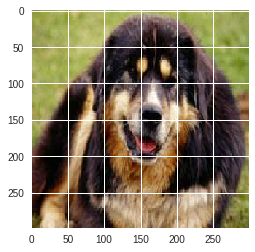

In [125]:
from PIL import Image

number = np.arange(120)

for n in number:
  if n < 10:
    img = Image.open('MO444_dogs/train/80/80_000'+str(n)+'.jpg')
  else:
    Image.open('MO444_dogs/train/80/80_00'+str(n)+'.jpg')

  img = img.resize((image_size[0],image_size[1]))

  imshow(img)
  

  #print(image_size)

  arr = np.array(img)

  #print(np.shape(arr))

  arr = arr.reshape((image_size[0],image_size[1],3))
  arr = np.expand_dims(arr, axis=0)
  
  #print(arr)
  
  arr = arr/255.0

  #print(arr)

  prediction = model.predict(arr)[0]
  #print(prediction)

  bestclass = ''
  bestconf = -1
  for n in range(83):
    if (prediction[n] > bestconf):
      bestclass = str(n)
      bestconf = prediction[n]
  print('I think this digit is a ' + bestclass + ' with ' + str(bestconf * 100) + '% confidence.')

!pip install keras==2.0.0

In [77]:
!pip install keras==2.0.0

  Found existing installation: Keras 2.1.5
    Uninstalling Keras-2.1.5:
      Successfully uninstalled Keras-2.1.5


# Reseting notebook

In [0]:
# Reset notebook
!kill -9 -1